# Midterm Progress For Master Thesis "Machine Learning Approach to Polkadots Validator Election Algorithm"

### 1. Introduction

#### Polkadot Election of active set of validators occurs every 24 hours.
#### The active set of validators is the set of validators that are eligible to produce blocks in the next 24 hours.
#### The active set is currently chosen by the Phragmén algorithm.
#### The Phragmén algorithm is an iterative method for electing a committee with proportional justified representation.
#### Each solution has a "security score" which is determined by 3 factors:
##### 1. maximise: the minimally staked validator of the active set
##### 2. maximise: the sum of stake of the active set
##### 3. minimise: the variance of the stakes of the active set
##### The current configuration allows for a "staking miner" (role in experimental phase) to propose solutions to the system. The criteria get judged in order and as soon as one of the criteria is not met, the solution is rejected. The staking miner is incentivised to propose solutions that are as close to the optimal solution as possible.

#### Breakdown into three parts:
# 1. Model 1: Classification model: Active Set Prediction --> (297/~1000) every 24 hours (done)
## 1.1 Data Acquisition via storage queries (takes about 8 hours to gather data for 1 year)
#### 1.1.1 Snapshot of Nominators, their stake and their vote preferences (up to 16 validators) (leads to graph of max 22500 nominators with max 16 votes == 360000 edges per day)
#### 1.1.2 SolutionStored: The solution posted by staking miner by running sequential phragmén algorithm
#### 1.1.3 Local Sequential Phragmén: Running the sequential phragmén algorithm locally for a longer time to acquire a better solution than the one posted by the staking miner
## 1.2 Data Preprocessing
### 1.2.1 Feature engineering, Feature selection, Feature scaling
### 1.2.2 Index mapping (validator+nominator address to index)
### 1.2.3 Restructuring of data to avoid curse of dimensionality (one-hot encoding of votes)
## 1.3 Exploratory Data Analysis
### 1.3.1 Pairwise comparison of active set
### 1.3.2 Cumulative elected validator distribution
### 1.3.3 Validator election frequency distribution
## 1.4 Model Selection, Training & Prediction
### 1.4.1 Random Forest Classifier
### 1.4.2 Logistic Regression

# 2. Model 2: Regression model:     Prediction of Stake ("vote") distribution amongst the active set (in progress)
## 2.1 Data Acquisition
### 2.1.1 trivial, can take previously acquired data and transform for regression model
## 2.2 Data Preprocessing
### 2.2.1 Feature engineering, Feature selection, Feature scaling
## 2.3 Exploratory Data Analysis
###
## 2.4 Model Selection, Training & Prediction
### 2.4.1 Optuna for hyperparameter tuning (Model and hyperparameter selection) guided by fitness function of 3 metrics (currently 1 metric)

# 3. Pipeline (in progress)
# Data acquisition --> Data preprocessing (both models) --> Model selection --> Model training & prediction (first active set then distribution) --> Model evaluation (scoring by 3 metrics) --> comparison with current solution --> pushing of solution to chain
## 3.1 Data Acquisition
### 3.1.1 automatic snapshot acquisition via subscription of storage queries (90% done)
## 3.2 Configuration via pyproject.toml
## 3.3 Future Work
### 3.3.1 Finishing of pipeline, ensuring modular design thus enabling connection to various blockchains and executing any predictions on the chain. (in progress)
### 3.3.2 Potentially looking into NEAT (NeuroEvolution of Augmenting Topologies) for model selection. Since data might not be informative enough for trivial models, NEAT might be able to produce more accurate/or more close predictions to the optimal solution. (in progress)


## 0. Importing the libraries


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# 1. Model 1: Active Set Prediction


## 1.1 Data Preprocessing

In [15]:
df = pd.read_csv("../data_collection/snapshot_with_solution.csv")
df.rename(columns={'Unnamed: 0': 'validator'}, inplace=True)
df.drop(columns=['self_stake'], inplace=True)

## 1.2 Exploratory Data Analysis

In [16]:
df.describe()

,total_bond,proportional_bond,nominator_count,elected_current_era,elected_previous_era,elected_counter,avg_stake_per_nominator,era
count,4.922710e+05,4.922710e+05,492271.000000,492271.000000,492271.000000,492271.000000,4.922710e+05,492271.000000
mean,5.395138e+16,5.105592e+15,188.733421,0.242537,0.232770,32.850385,4.110231e+15,787.080106
std,9.164648e+16,8.138970e+15,433.395726,0.428618,0.422597,80.206919,2.716217e+16,117.870433
min,0.000000e+00,0.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000e+00,590.000000
25%,9.557382e+13,6.978229e+12,2.000000,0.000000,0.000000,0.000000,1.661854e+12,682.000000
50%,5.392559e+15,4.377818e+14,12.000000,0.000000,0.000000,0.000000,7.181366e+12,785.000000
75%,7.470571e+16,9.546983e+15,153.000000,0.000000,0.000000,0.000000,6.574346e+13,890.000000
max,9.009553e+17,1.340960e+17,4370.000000,1.000000,1.000000,401.000000,3.200000e+17,995.000000


### 1.2.1 Pairwise comparison of active set

In [28]:
%matplotlib notebook
era_index = []
set_difference = []
for i in range(590,950):
    df1 = set(df[(df['era'] == i) & (df['elected_current_era'] == 1)]['validator'])
    df2 = set(df[(df['era'] == i+1) & (df['elected_current_era'] == 1)]['validator'])
    era_index.append(i)
    set_difference.append(len(df1.difference(df2)))
plt.title("pairwise difference of active sets")
plt.xlabel("era_index")
plt.ylabel("count")
plt.plot(era_index[1:], set_difference[1:])

<IPython.core.display.Javascript object>

In [11]:
# set the elected counter equal at all validators of same address.
validators = set(df.validator.unique())
count_adapted_df = df.copy()
for validator in validators:
    counters = set(count_adapted_df.loc[count_adapted_df['validator'] == validator].elected_counter)
    maxcounter = max(counters)
    count_adapted_df.loc[count_adapted_df['validator'] == validator, 'elected_counter'] = maxcounter

### 1.2.2 Cumulative elected validator distribution

Text(0.5, 1.0, 'Cumulative elected validator distribution')

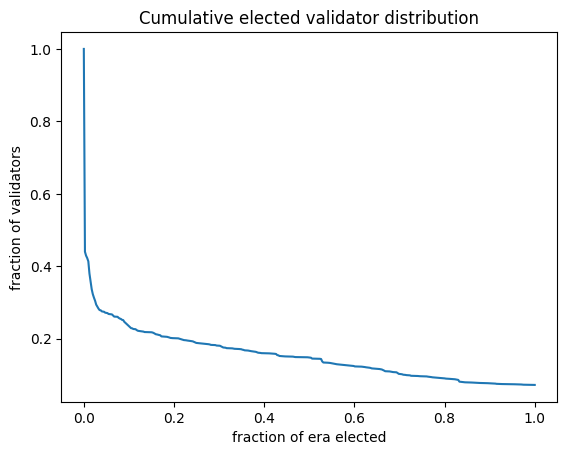

In [12]:
grouped_df = count_adapted_df.copy()
#df55 = df55[df55['elected_counter'] != 374]
grouped_df= grouped_df.groupby(['validator', 'elected_counter']).count().reset_index()
grouped_df = grouped_df.elected_counter.value_counts().sort_index(ascending=False).reset_index()

grouped_df['index'] = grouped_df['index'].div(grouped_df['index'].max())
grouped_df['elected_counter'] = grouped_df['elected_counter'].div(grouped_df['elected_counter'].sum())
#plt.hist(grouped_df['index'], 200, histtype="stepfilled", alpha=.7, cumulative=-1)
cumsum = np.cumsum(grouped_df['elected_counter'])
plt.plot(grouped_df['index'], cumsum, )
plt.xlabel('fraction of era elected')
plt.ylabel('fraction of validators')
plt.title('Cumulative elected validator distribution')


### 1.2.3 Validator election frequency distribution

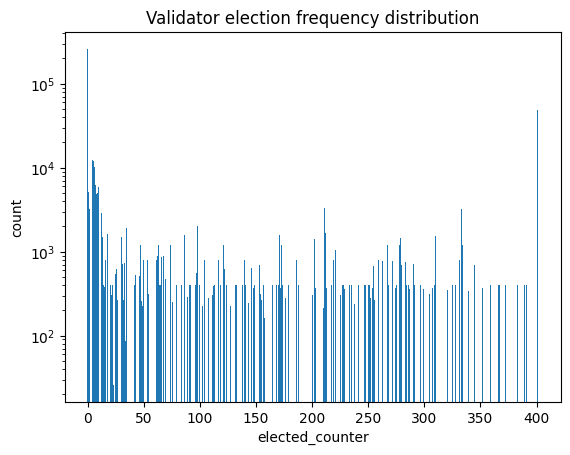

In [13]:
df2 = count_adapted_df.groupby(["elected_counter"]).size().reset_index(name='counter')
plt.bar(df2['elected_counter'], df2['counter'])
plt.xlabel("elected_counter")
plt.ylabel("count")
plt.yscale('log')
plt.title("Validator election frequency distribution")
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.show()

/tmp/ipykernel_110070/401936872.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), cmap="Blues", annot=True)


<Axes: >

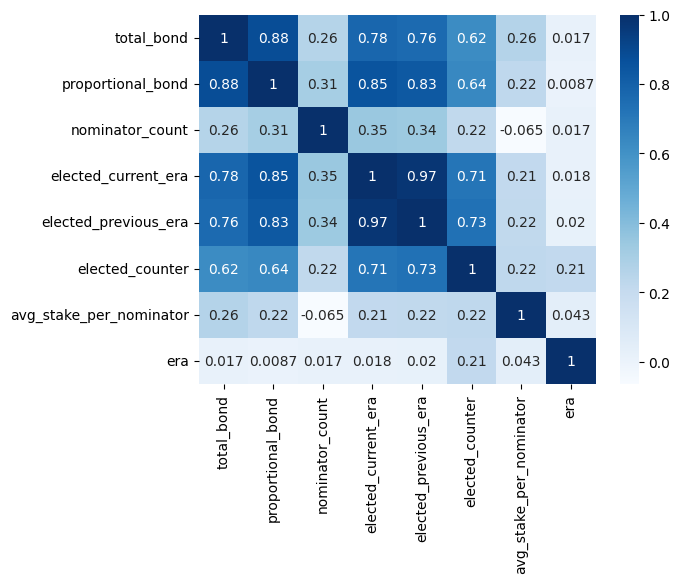

In [17]:
sns.heatmap(df.corr(), cmap="Blues", annot=True)

# Description of absolute losers (elected_counter == 0)

In [19]:
loser_df = count_adapted_df.copy()
loser_df = loser_df.loc[(loser_df['elected_counter'] == 0) & (loser_df['elected_current_era'] == 0)]
describe_loser_df = loser_df.describe()
describe_loser_df.reset_index(inplace=True)
describe_loser_df = describe_loser_df[describe_loser_df['index'] != 'count']
describe_loser_df.columns

Index(['index', 'total_bond', 'proportional_bond', 'nominator_count',
       'elected_current_era', 'elected_previous_era', 'elected_counter',
       'self_stake', 'avg_stake_per_nominator', 'era'],
      dtype='object')

## Description of Winners (elected_counter == 374)

In [20]:
winner_df = count_adapted_df.copy()
winner_df = winner_df.loc[winner_df['elected_counter'] == 401]
describe_winner_df = winner_df.describe()
describe_winner_df.reset_index(inplace=True)
describe_winner_df = describe_winner_df[describe_winner_df['index'] != 'count']


In [21]:
#winner_df.describe().to_frame('data').boxplot(meanline=True, showmeans=True)
#describe_winner_df['total_bond'].to_frame('data').boxplot(meanline=True, showmeans=True)
concated_dfs = []
for index, column in enumerate(describe_winner_df.columns):
    concated_dfs.append(pd.concat([describe_winner_df[column], describe_loser_df[column]], axis=1))
    concated_dfs[index].columns = ["winner", "loser"]

Text(0.5, 1.0, 'total bond')

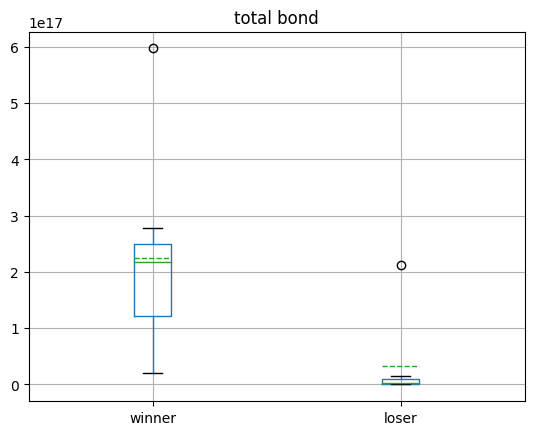

In [22]:
concated_dfs[1].boxplot(meanline=True, showmeans=True)
plt.title("total bond")

Text(0.5, 1.0, 'proportional bond')

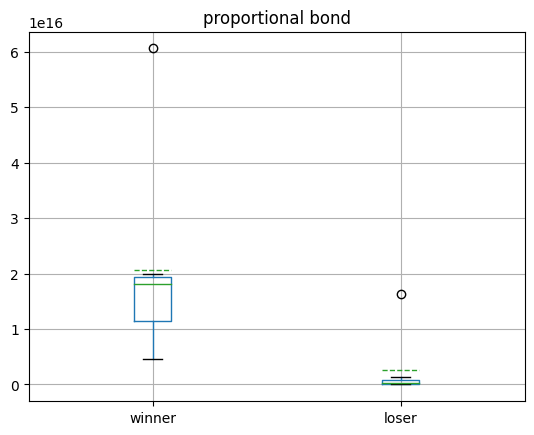

In [23]:
concated_dfs[2].boxplot(meanline=True, showmeans=True)
plt.title("proportional bond")

Text(0.5, 1.0, 'nominator count')

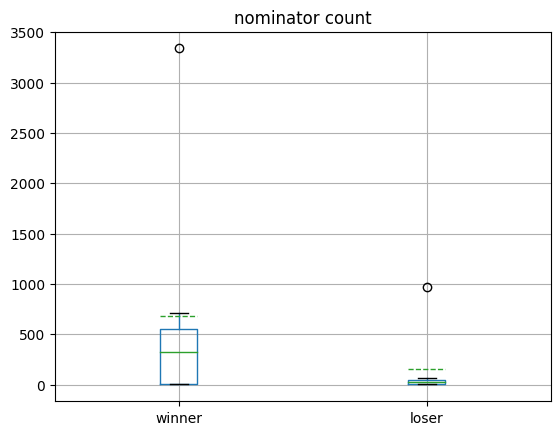

In [24]:
concated_dfs[3].boxplot(meanline=True, showmeans=True)
plt.title("nominator count")

Text(0.5, 1.0, 'avg stake')

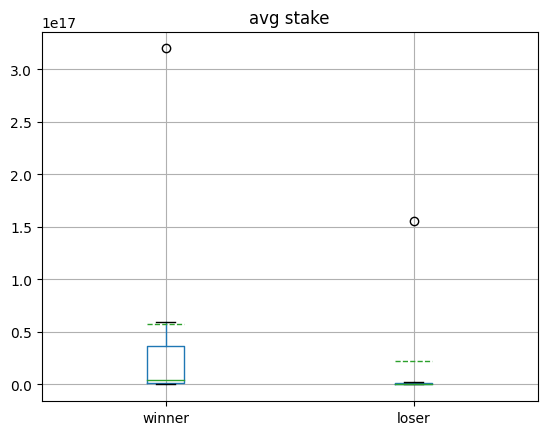

In [25]:
concated_dfs[8].boxplot(meanline=True, showmeans=True)
plt.title("avg stake")

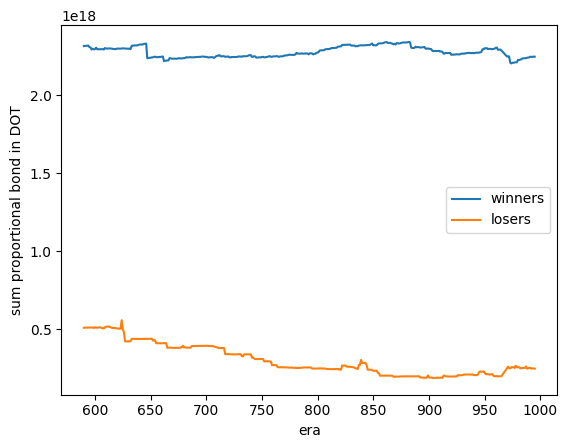

In [26]:
proportional_bonds_winners = winner_df.groupby("era").sum('proportional_bond').reset_index()
proportional_bonds_losers = loser_df.groupby("era").sum('proportional_bond').reset_index()
plt.plot(proportional_bonds_winners['era'], proportional_bonds_winners['proportional_bond'])
plt.plot(proportional_bonds_losers['era'], proportional_bonds_losers['proportional_bond'])
plt.xlabel("era")
plt.ylabel("sum proportional bond in DOT")
plt.legend(["winners", "losers"])
plt.show()